In [1]:
import ta_functions as ta
import yfinance as yf
import pandas as pd
import numpy as np

from scipy.stats import norm

from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline

from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
TICKERS = ["TSLA", "NVDA", "COIN", "SHOP", "NKE", "SMCI", "XPEV", "NIO", "GOOGL", "AAPL", "UNH", "XYZ"]
YEARS_OF_DATA = 2
PROFIT_TARGET = 0.03
STOP_LOSS = 0.03
FORWARD_DAYS = 14 # For prediction
future_window = 14  # Backtesting

tolerance = 1.07

# Time window
end_date = datetime.now()
start_date = end_date - timedelta(days=365 * YEARS_OF_DATA)

# Shared model components
FEATURES = ['RSI', 'RSI_SMA', 'SMA1', 'SMA2', 'SMA3', 'SMA_Ratio', 'MACD', 'Signal_Line',
            'Upper_Band', 'Lower_Band', 'Volume_MA20',
            '5_day_return', '10_day_return', 'Volatility',
            'CCI', 'OBV', '+DI', '-DI', 'ADX', 'ATR', 
            'VWMA', 'VI+','VI+', 'KCu','KCl', 'STu', 'STl', 'Candlesticks',
           'Bear', 'Bull', 'vSpike', 'DD']

results = []


In [3]:
# Functions
def get_stock_data(ticker, start_date, end_date):
    #print("Getting data for:   ", ticker)
    df = yf.download(ticker, start=start_date, end=end_date + timedelta(days=1), 
                     interval='1d', auto_adjust=False, progress=False)
    df = df.reset_index()
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]
    df.dropna()
    return df

def add_technical_indicators(df):
    df['SMA1'] = df['Close'].rolling(window=12).mean()
    df['SMA2'] = df['Close'].rolling(window=24).mean()
    df['SMA3'] = df['Close'].rolling(window=52).mean()
    df['SMA_Ratio'] = df['SMA1'] / df['SMA2']
    
    df['Bear'] = (df['SMA1'] < df['SMA2']).astype(int)
    df['Bull'] = (df['SMA2'] < df['SMA1']).astype(int)
    df['RSI']= ta.calculate_rsi(df)
    df['RSI_SMA'] = df['RSI'] / df['RSI'].rolling(14).mean()
    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=24, adjust=False).mean()
    df['MACD'] = ema12 - ema26
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['Upper_Band'] = df['SMA1'] + (2 * df['Close'].rolling(20).std())
    df['Lower_Band'] = df['SMA1'] - (2 * df['Close'].rolling(20).std())
    df['Volume_MA20'] = df['Volume'].rolling(window=20).mean()
    df['vSpike'] = (df['Volume'] > 2 * df['Volume_MA20']).astype(int)
    
    df['CCI'] = ta.calculate_cci(df)
    df['OBV'] = ta.calculate_obv(df)
    df[['+DI', '-DI', 'ADX']] = ta.calculate_dmi(df, n=14)
    df['ATR'] = ta.calculate_atr(high=df.High, low=df.Low, close=df.Close)
    
    df['VWMA'] = ta.calculate_vwma(df)
    df[['KCm', 'KCu', 'KCl']] = ta.calculate_keltner(df)
    df[['VI+', 'VI-']] = ta.calculate_vortex(df)
    df[['STu', 'STl']] = ta.calculate_supertrend(df)
    
    df = ta.add_candlestickpatterns(df)
    
    df['DD'] = df['Close'].where(df['Close'] < df['Close'].shift(1)).std()

    df['5_day_return'] = df['Close'].pct_change(5)
    df['10_day_return'] = df['Close'].pct_change(10)
    df['Volatility'] = df['Close'].rolling(14).std()
    
    return df

def compute_expected_return(df):
    df['5_day_return'] = df['Close'].pct_change(int(FORWARD_DAYS/2))
    df['10_day_return'] = df['Close'].pct_change(FORWARD_DAYS)
    df['Volatility'] = df['Close'].rolling(FORWARD_DAYS).std()
    df['Expected_Return'] = np.nan
    close_prices = df['Close'].values
    for i in range(len(close_prices) - FORWARD_DAYS):
        current_price = close_prices[i]
        future_max = np.nanmax(close_prices[i + 1:i + 1 + FORWARD_DAYS])
        expected_return = (future_max - current_price) / current_price
        df.iloc[i, df.columns.get_loc('Expected_Return')] = expected_return
    return df

def compute_expected_loss(df):
    df['Expected_Loss'] = np.nan
    close_prices = df['Close'].values
    for i in range(len(close_prices) - FORWARD_DAYS):
        current_price = close_prices[i]
        future_min = np.nanmin(close_prices[i + 1:i + 1 + FORWARD_DAYS])
        expected_loss = (future_min - current_price) / current_price
        df.iloc[i, df.columns.get_loc('Expected_Loss')] = expected_loss
    return df

def add_lagged_features(df, lags=[1, 2, 3]):
    for lag in lags:
        for feature in FEATURES:
            if feature in df.columns:
                df[f"{feature}_lag{lag}"] = df[feature].shift(lag)
    return df

def initialize_XGBR():
    model = XGBRegressor(
        n_estimators=200,
        max_depth=7,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        random_state=42
    )
    return model


In [4]:
for ticker in TICKERS:
    try:
        df = get_stock_data(ticker, start_date, end_date)
        df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')
        df = add_technical_indicators(df)
        df = compute_expected_return(df)
        df = compute_expected_loss(df)  # Add loss calculation
        
        df_model = df.dropna(subset=FEATURES + ['Expected_Return', 'Expected_Loss'])
        
        if len(df_model) < 50:
            continue

        # Train return model
        X = df_model[FEATURES]
        y_return = df_model['Expected_Return']
        scaler_return = StandardScaler()
        X_scaled_return = scaler_return.fit_transform(X)
        
        model_return = RandomForestRegressor(
        n_estimators=200,         
        max_depth=10,               
        min_samples_leaf=5,        
        max_features='sqrt',       
        ccp_alpha=0.01               
        )
        model_return.fit(X_scaled_return, y_return)

        # Train loss model
        y_loss = df_model['Expected_Loss']
        scaler_loss = StandardScaler()
        X_scaled_loss = scaler_loss.fit_transform(X)
        
        model_loss = RandomForestRegressor(
        n_estimators=200,         
        max_depth=10,               
        min_samples_leaf=5,        
        max_features='sqrt',       
        ccp_alpha=0.01               
        )
        model_loss.fit(X_scaled_loss, y_loss)

        latest = df.iloc[[-1]]
        if latest[FEATURES].isnull().values.any():
            continue
            
        # Predict both return and loss
        latest_scaled_return = scaler_return.transform(latest[FEATURES])
        latest_scaled_loss = scaler_loss.transform(latest[FEATURES])
        predicted_return = model_return.predict(latest_scaled_return)[0]
        predicted_loss = model_loss.predict(latest_scaled_loss)[0]

        entry_price = latest['Close'].values[0]
        predicted_tp = entry_price * (1 + predicted_return)
        predicted_sl = entry_price * (1 + predicted_loss)  # Using predicted loss for SL
        optimal_entry = (predicted_sl + entry_price) / 2  # Average of predicted SL and TP
        entry_discount_pct = ((optimal_entry-entry_price) / entry_price) * 100

        # Technical condition check
        current_price = latest['Close'].values[0]
        sma1 = latest['SMA1'].values[0]
        sma2 = latest['SMA2'].values[0]
        rsi = latest['RSI'].values[0]

        results.append({
            "Ticker": ticker,
            "Date": latest.index[-1].date(),
            "Price": round(entry_price, 1),
            "Entry": round(optimal_entry, 1),
            "Entry%": round(entry_discount_pct, 1),
            "Max (%)": round(predicted_return * 100, 1),
            "TP": round(predicted_tp, 1),
            "SL": round(predicted_sl, 1),
            "Loss (%)": round(predicted_loss * 100, 1),
            "Signal": "✅ Bullish" if (current_price > sma1 and sma1 > sma2 and rsi > 52) else "⚠️ Neutral",
            "Risk": "⚠️ High Risk" if abs(predicted_loss) > STOP_LOSS else "🟢 Low Risk"
        })

    except Exception as e:
        print(f"Error processing {ticker}: {e}")

# Display results
df_results = pd.DataFrame(results)
print("\n=== Multi-Ticker Prediction Table (Modified) ===")
print(tabulate(df_results, headers='keys', tablefmt='plain'))


=== Multi-Ticker Prediction Table (Modified) ===
    Ticker    Date          Price    Entry    Entry%    Max (%)     TP     SL    Loss (%)  Signal      Risk
 0  TSLA      2025-06-26    325.8    316.3      -2.9        6.4  346.8  306.8        -5.8  ⚠️ Neutral  ⚠️ High Risk
 1  NVDA      2025-06-26    155      148.7      -4.1        0.7  156.1  142.3        -8.2  ✅ Bullish  ⚠️ High Risk
 2  COIN      2025-06-26    375.1    345.7      -7.8        0.1  375.3  316.4       -15.6  ✅ Bullish  ⚠️ High Risk
 3  SHOP      2025-06-26    113.1    107.8      -4.6        5.3  119.1  102.6        -9.3  ✅ Bullish  ⚠️ High Risk
 4  NKE       2025-06-26     62.5     61.2      -2.2        3.5   64.8   59.8        -4.4  ⚠️ Neutral  ⚠️ High Risk
 5  SMCI      2025-06-26     49.3     43.9     -10.9      -13.4   42.7   38.6       -21.7  ✅ Bullish  ⚠️ High Risk
 6  XPEV      2025-06-26     18       17.5      -2.4        7.7   19.3   17.1        -4.9  ⚠️ Neutral  ⚠️ High Risk
 7  NIO       2025-06-26      3.4 

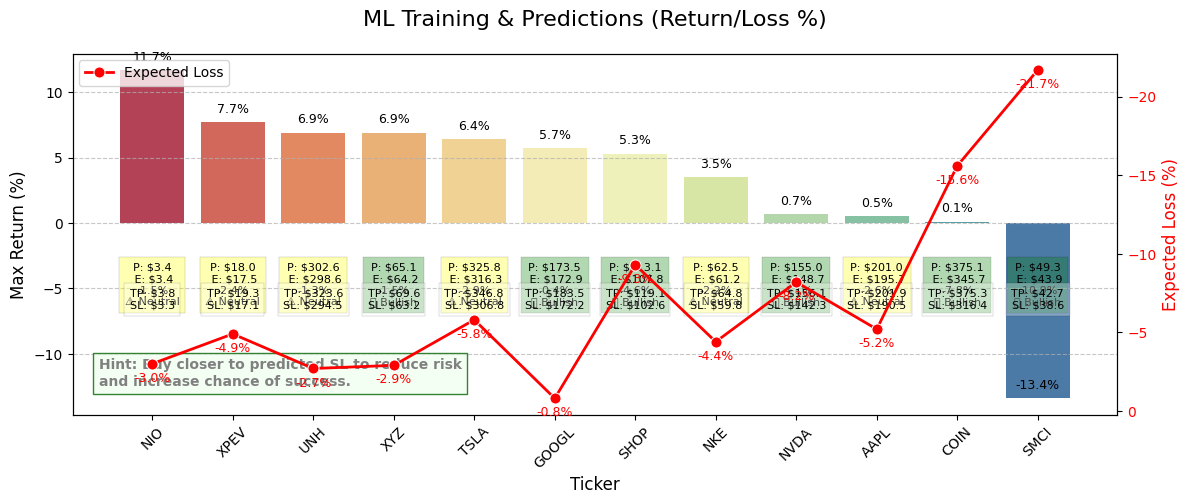

In [5]:
# ✅ PLOT PREDICTIONS
from matplotlib.offsetbox import AnchoredText

df_plot = df_results.sort_values(by="Max (%)", ascending=False)

# Create figure with adjusted bottom margin
fig, ax1 = plt.subplots(figsize=(12, 6), dpi=100)  # Original size

# --- MAIN PLOT (original styling) ---
sns.barplot(x="Ticker", y="Max (%)", data=df_plot, palette="Spectral", ax=ax1)
ax1.set_ylabel('Max Return (%)', fontsize=12)
ax1.set_ylabel('Max Return (%)', fontsize=12)
ax1.set_xlabel('Ticker', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)


# --- SECONDARY AXIS (original styling) ---
ax2 = ax1.twinx()
sns.lineplot(x="Ticker", y="Loss (%)", data=df_plot, color='red', marker='o', 
             ax=ax2, linewidth=2, markersize=8, label='Expected Loss')
ax2.set_ylabel('Expected Loss (%)', fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.invert_yaxis()

    
# --- FIXED ANNOTATION POSITIONS ---
for i, (_, row) in enumerate(df_plot.iterrows()):
    
    fcolor = 'green' if row.Signal == "✅ Bullish" else 'yellow'
        
    # Top annotations (unchanged)
    ax1.text(i, row["Max (%)"] + 0.5, f'{row["Max (%)"]:.1f}%', 
             ha='center', va='bottom', fontsize=9)
    ax2.text(i, row["Loss (%)"] + 0.5, f'{row["Loss (%)"]:.1f}%', 
             ha='center', va='top', color='red', fontsize=9)
    
    # Bottom annotations (FIXED)
    vertical_offset = 3  # Base offset in percentage points
    off1 = vertical_offset + 2  # Additional space for Entry box
    off2 = vertical_offset # TP/SL at base offset
    
    ax1.text(i, -off2, 
             f'P: ${row["Price"]:.1f}\n E: ${row["Entry"]:.1f}\n{row["Entry%"]:.1f}%\n{row["Signal"]}',
             ha='center', va='top', fontsize=8, 
             bbox=dict(facecolor=fcolor, alpha=0.3, linewidth=0.3))
    
    ax1.text(i, -off1, 
             f'TP: ${row["TP"]:.1f}\nSL: ${row["SL"]:.1f}', 
             ha='center', va='top', fontsize=8, 
             bbox=dict(facecolor='white', alpha=0.3, linewidth=0.3))

# --- STRATEGIC HINT (original position but padded) ---
textbox = AnchoredText(
    "Hint: Buy closer to predicted SL to reduce risk\nand increase chance of success.",
    loc='lower left',
    frameon=True,
    borderpad=1.5,  # Increased padding
    prop=dict(size=10, color='gray', weight='bold')
)
ax1.add_artist(textbox)
textbox.patch.set_facecolor('honeydew')
textbox.patch.set_edgecolor('darkgreen')
textbox.patch.set_alpha(0.8)

# --- FINAL SPACE MANAGEMENT ---
plt.title("ML Training & Predictions (Return/Loss %)", fontsize=16, pad=20)
plt.tight_layout()
plt.subplots_adjust(bottom=0.3)  # Increased from default to protect x-labels
plt.show()

## TEST PROFITABILITY

Only trading when the price is (1Yr):

a) Above SMA20 days

b) RSI above 50

c) SMA20 > SMA50 days

d) SL is fixed like 3 to 5 %.

In [8]:
def compute_expected_return(df, window=5):
    """Calculate % return over the next `window` days."""
    df['Expected_Return'] = df['Close'].shift(-window) / df['Close'] - 1
    return df

def compute_expected_loss(df, window=5):
    """Calculate worst-case (minimum) % return over the next `window` days."""
    df['Expected_Loss'] = df['Close'].shift(-window).rolling(window).min() / df['Close'] - 1
    return df
def train_and_backtest(ticker="", train_years=2, show_every_n=10):
    # 1. Get and prepare data
    end_date = datetime.now()
    start_date = end_date - timedelta(days=365*train_years)
    df = get_stock_data(ticker, start_date, end_date)
    
    # Calculate all features
    df = add_technical_indicators(df)

    # 2. Train/Test split (no lookahead)
    train_df = df.iloc[:-252] if len(df) > 252 else df.copy()
    test_df = df.iloc[-252:].copy()

    # Compute future-based labels **after** split
    train_df = compute_expected_return(train_df, window=future_window)
    train_df = compute_expected_loss(train_df, window=future_window)
    
    # Drop rows with NaNs (from indicators or future shifts)
    train_df = train_df.dropna(subset=FEATURES + ['Expected_Return', 'Expected_Loss'])
    test_df = test_df.dropna(subset=FEATURES)

    # 2. Train models
    X_train = train_df[FEATURES]
    y_return = train_df['Expected_Return']
    y_loss = train_df['Expected_Loss']
    
    model_return = RandomForestRegressor(
        n_estimators=200,         
        max_depth=7,               
        min_samples_leaf=5,        
        max_features='sqrt',       
        ccp_alpha=0.01               
    )
    
    model_loss = RandomForestRegressor(
        n_estimators=200,          
        max_depth=7,               
        min_samples_leaf=5,        
        max_features='sqrt',       
        ccp_alpha=0.01  
    )
    
    model_return.fit(X_train, y_return)
    model_loss.fit(X_train, y_loss)

    # 3. Generate signals with TP/SL hit detection
    signals = []

    for i in range(10, len(test_df)):
        current = test_df.iloc[i:i+1]
        if current[FEATURES].isnull().values.any():
            continue

        # SETUP CONFIRMATIONS
        
        if (current['Close'].values[0] <= current['SMA1'].values[0]) and \
           (current['SMA1'].values[0] <= current['SMA2'].values[0]) or \
           (current['RSI'].values[0] <= 52):
            continue
            
        current_price = current['Close'].values[0]
        date = current.index[0]
        
        # Predict
        pred_return = model_return.predict(current[FEATURES])[0]
        pred_loss = model_loss.predict(current[FEATURES])[0]
        
        # Calculate levels
        sl_price = current_price * (1 + max(STOP_LOSS, pred_loss))
        tp_price = current_price * (1 + pred_return)
        optimal_entry = (tp_price + sl_price) / 2
        
        # Initialize trade details
        exit_price = np.nan
        result = "No Exit"
        holding_days = 0
        
        # Check price path for TP/SL hits
        if i + future_window < len(test_df):
            future_prices = test_df.iloc[i+1:i+future_window+1]['Close']
            
            # Check for TP hit
            tp_hit = future_prices[future_prices >= tp_price]
            if not tp_hit.empty:
                exit_price = tp_hit.iloc[0]
                result = "TP Hit"
                holding_days = future_prices.index.get_loc(tp_hit.index[0]) + 1
            
            # Check for SL hit (only if TP wasn't hit)
            if pd.isna(exit_price):
                sl_hit = future_prices[future_prices <= sl_price]
                if not sl_hit.empty:
                    exit_price = sl_hit.iloc[0]
                    result = "SL Hit"
                    holding_days = future_prices.index.get_loc(sl_hit.index[0]) + 1
            
            # If neither hit, use period-end price
            if pd.isna(exit_price):
                exit_price = future_prices.iloc[-1]
                result = "EOD Exit"
                holding_days = future_window
        
        signals.append({
            'Date': date,
            'Price': current_price,
            'TP': tp_price,
            'SL': sl_price,
            'Exit': exit_price,
            'Result': result,
            'Holding_Days': holding_days,
            'Return': (exit_price - current_price)/current_price if not pd.isna(exit_price) else np.nan,
            'Signal': current_price <= optimal_entry * tolerance 
        })
    
    signals_df = pd.DataFrame(signals).set_index('Date')
    signals_df = signals_df[signals_df['Return'].notna()]
    
    # 4. Calculate Statistics
    trades = signals_df[signals_df['Signal']]
    
    if len(trades) == 0:
        print(f"[{ticker}] No valid trades generated.")
        return pd.DataFrame(), {}

    # Separate successful and failed trades
    successful = trades[trades['Return'] > 0]
    failed = trades[trades['Return'] <= 0]
    
    stats = {
        'Total Trades': len(trades),
        'Win Rate': len(successful)/len(trades) if len(trades) > 0 else 0,
        'Avg Return': trades['Return'].mean(),
        'Median Return': successful['Return'].median() if len(successful) > 0 else 0,
        'Avg Win': successful['Return'].mean() if len(successful) > 0 else 0,
        'Median Win': successful['Return'].median() if len(successful) > 0 else 0,
        'Max Gain': trades['Return'].max(),
        'Avg Loss': failed['Return'].mean() if len(failed) > 0 else 0,
        'Median Loss': failed['Return'].median() if len(failed) > 0 else 0,
        'Max Loss': trades['Return'].min(),
        'Avg Holding Days': trades['Holding_Days'].mean(),
        'TP Hit Rate': (trades['Result'] == 'TP Hit').mean(),
        'SL Hit Rate': (trades['Result'] == 'SL Hit').mean(),
        'Return/Risk': -successful['Return'].mean()/failed['Return'].mean() if (len(failed) > 0 and len(successful) > 0) else 0,
        'Profit Factor': abs(successful['Return'].sum()/failed['Return'].sum()) if len(failed) > 0 else float('inf')
    }

    # 5. Enhanced Visualization
    plt.figure(figsize=(16, 12))
    grid = plt.GridSpec(4, 1, height_ratios=[3, 1, 1, 1])
    
    # Price Chart
    ax1 = plt.subplot(grid[0])
    plt.plot(test_df.index, test_df['Close'], label='Price', color='grey', alpha=0.6)
    plt.plot(test_df.index, test_df['SMA1'], label='MA12', color='orange', alpha=0.6)
    plt.plot(test_df.index, test_df['SMA2'], label='MA24', color='red', alpha=0.6)
    
    # Create fill between SMAs
    plt.fill_between(test_df.index,
                     test_df['SMA1'],
                     test_df['SMA2'],
                     where=(test_df['SMA1'] > test_df['SMA2']),
                     interpolate=True,
                     color='limegreen',
                     alpha=0.2,
                     label='Bullish',
                     zorder=0)
    
    plt.fill_between(test_df.index,
                     test_df['SMA1'],
                     test_df['SMA2'],
                     where=(test_df['SMA1'] < test_df['SMA2']),
                     interpolate=True,
                     color='tomato',
                     alpha=0.2,
                     label='Bearish',
                     zorder=0)
    
    # Plot signals
    sample = trades.iloc[::show_every_n]
    
    # Entry points
    plt.scatter(sample.index, sample['Price'], color='green', 
                marker='^', s=20, label='Entry', zorder=3, alpha = 0.5)
    
    # Exit points (color by result)
    colors = {'TP Hit':'blue', 'SL Hit':'red', 'EOD Exit':'gray'}
    for result, group in sample.groupby('Result'):
        plt.scatter(group.index, group['Exit'], 
                    color=colors[result], marker='o', 
                    s=20, label=f'{result}', zorder=2, alpha = 0.5)
    
    # Annotations
    for date, row in sample.iterrows():
        if row['Return'] > 0:  # Winning trade (TP)
            plt.annotate(f"TP: {row['TP']:.1f}\n({row['Return']:.1%})",
                        (date, row['TP']), 
                        xytext=(0,10),  # 10 points above
                        textcoords='offset points', 
                        ha='center', 
                        va='bottom',  # Anchor text bottom to point
                        color='green',  # Different color for TP
                        fontsize=8,
                        bbox=dict(boxstyle='round,pad=0.2', 
                                  facecolor='white', 
                                  alpha=0.8,
                                  edgecolor='none'))
        
        else:  # Losing trade (SL)
            plt.annotate(f"SL: {row['SL']:.1f}\n({row['Return']:.1%})",
                        (date, row['SL']), 
                        xytext=(0,-10),  # 10 points below
                        textcoords='offset points', 
                        ha='center', 
                        va='top',  # Anchor text top to point
                        color='red',  # Different color for SL
                        fontsize=8,
                        bbox=dict(boxstyle='round,pad=0.2', 
                                  facecolor='white', 
                                  alpha=0.8,
                                  edgecolor='none'))
    
    plt.title(f"{ticker} Backtest Results | {start_date.date()} to {end_date.date()}")
    plt.legend()
    plt.grid(True)

    # Add RSI with curved fill
    axRSI = plt.subplot(grid[1])
    rsi_line = plt.plot(test_df.index, test_df['RSI'], label='RSI', color='grey', alpha=0.6, zorder=2)
    
    # Fill above 50 (green)
    plt.fill_between(test_df.index, 
                     test_df['RSI'], 
                     50, 
                     where=(test_df['RSI'] >= 50),
                     interpolate=True,
                     color='limegreen', 
                     alpha=0.2,
                     zorder=1)
    
    # Fill below 50 (red)
    plt.fill_between(test_df.index, 
                     test_df['RSI'], 
                     50, 
                     where=(test_df['RSI'] <= 50),
                     interpolate=True,
                     color='tomato', 
                     alpha=0.2,
                     zorder=1)
    
    # Keep your original elements
    plt.axhline(50, color='red', linestyle='-', alpha=0.2, zorder=0)
    plt.legend()
    plt.grid(False)
    plt.ylabel('RSI')
        
    # Returns Distribution
    ax2 = plt.subplot(grid[2])
    plt.hist(trades['Return'], bins=20, color='skyblue', edgecolor='black')
    plt.axvline(x=0, color='red', linestyle='--')
    plt.title('Returns Distribution')
    plt.xlabel(f'{future_window}-day Return')
    plt.ylabel('Frequency')
    plt.grid(True)
    
    # Cumulative Returns
    CAPITAL = 1000
    ax3 = plt.subplot(grid[3])
    cumulative_returns = (1 + trades['Return']).cumprod()
    (cumulative_returns * CAPITAL).plot(color='green', label='Strategy')
    plt.axhline(y=CAPITAL, color='red', linestyle='--')
    plt.title('Cumulative Returns')
    plt.ylabel(f'Growth of ${CAPITAL}')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # 6. Print Statistics
    print(f"\n=== {ticker} Backtest Results ===")
    print(f"Period: {test_df.index[0].date()} to {test_df.index[-1].date()}")
    print(f"Total Trades: {stats['Total Trades']}")
    print(f"Win Rate: {stats['Win Rate']:.1%}")
    print(f"Avg Return: {stats['Avg Return']:.2%}")
    print(f"Avg Win: {stats['Avg Win']:.2%}")
    print(f"Avg Loss: {stats['Avg Loss']:.2%}")
    print(f"Median Return: {stats['Median Return']:.2%}")
    print(f"Avg Holding Days: {stats['Avg Holding Days']:.1f}")
    print(f"TP Hit Rate: {stats['TP Hit Rate']:.1%}")
    print(f"SL Hit Rate: {stats['SL Hit Rate']:.1%}")
    print(f"Max Gain: {stats['Max Gain']:.2%}")
    print(f"Max Loss: {stats['Max Loss']:.2%}")
    print(f"Return/Risk Ratio: {stats['Return/Risk']:.2f}")
    print(f"Profit Factor: {stats['Profit Factor']:.2f}")
    print(f"\nAvg Win/Loss {stats['Avg Win']:.2%} to {stats['Avg Loss']:.2%}")
    
    return trades, stats

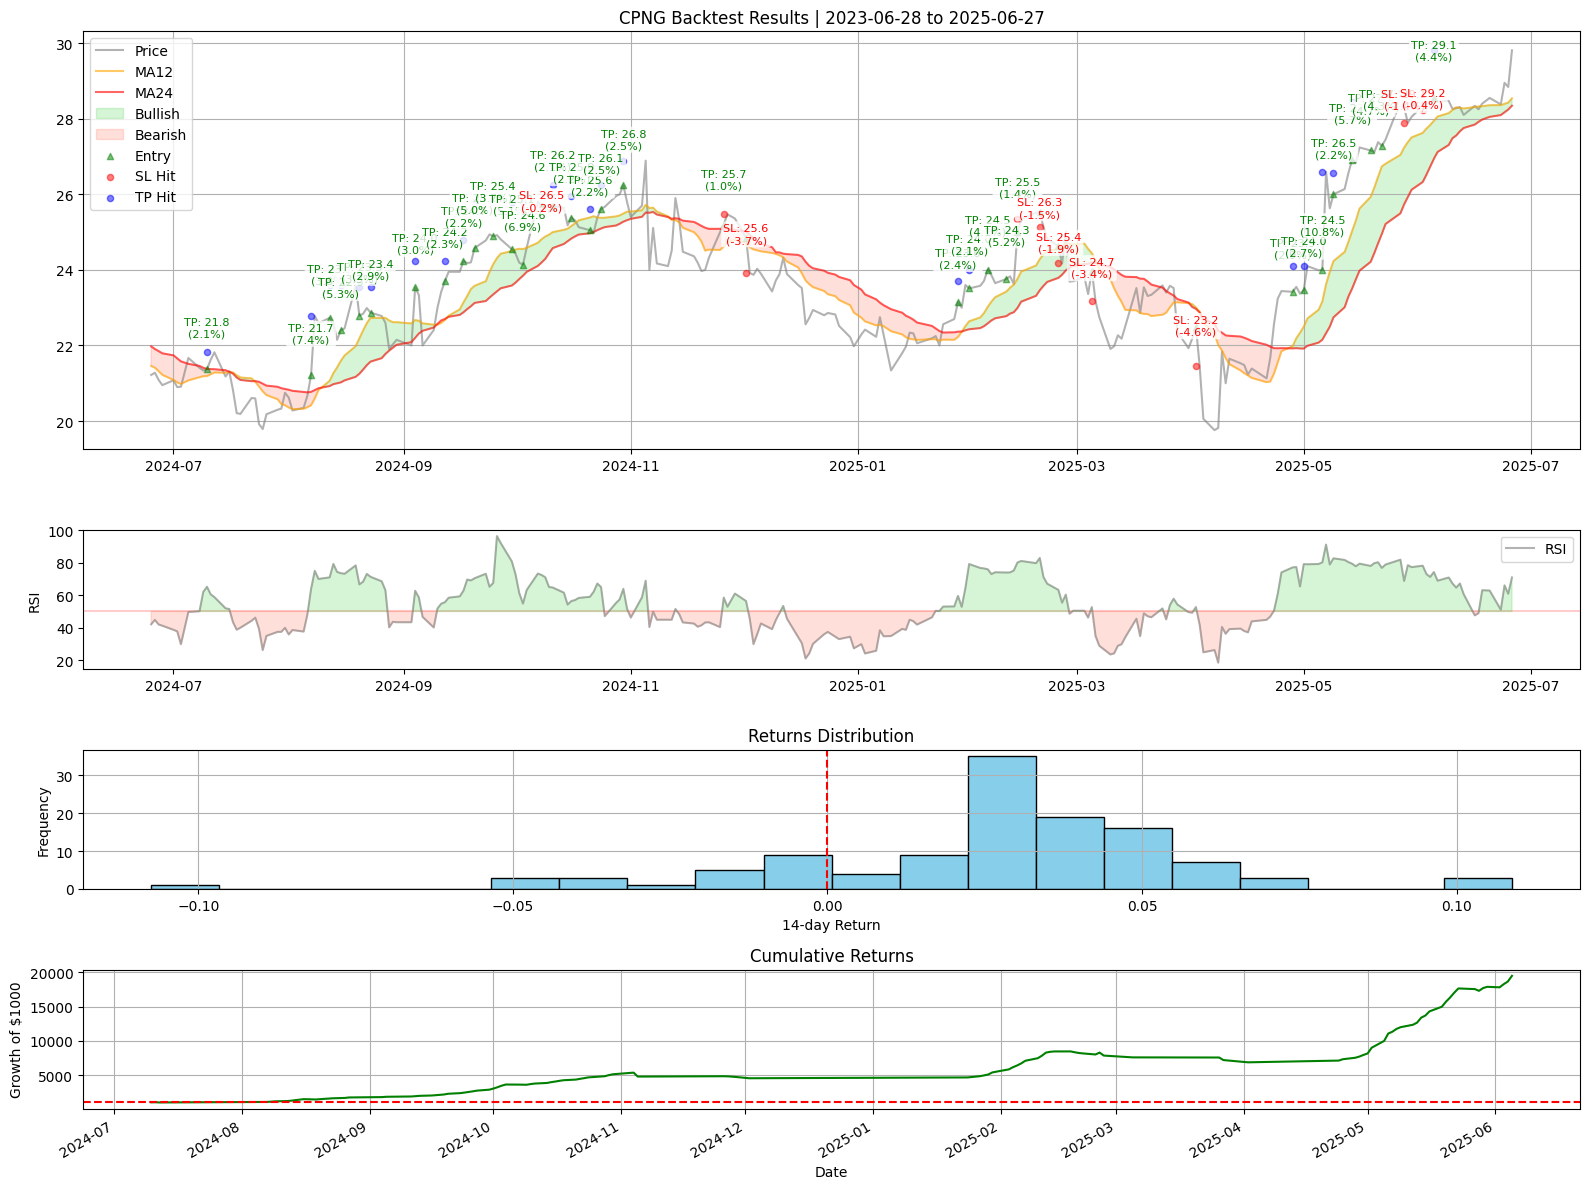


=== CPNG Backtest Results ===
Period: 2024-06-25 to 2025-06-26
Total Trades: 118
Win Rate: 82.2%
Avg Return: 2.60%
Avg Win: 3.68%
Avg Loss: -2.41%
Median Return: 3.29%
Avg Holding Days: 4.1
TP Hit Rate: 77.1%
SL Hit Rate: 22.9%
Max Gain: 10.88%
Max Loss: -10.75%
Return/Risk Ratio: 1.53
Profit Factor: 7.06

Avg Win/Loss 3.68% to -2.41%


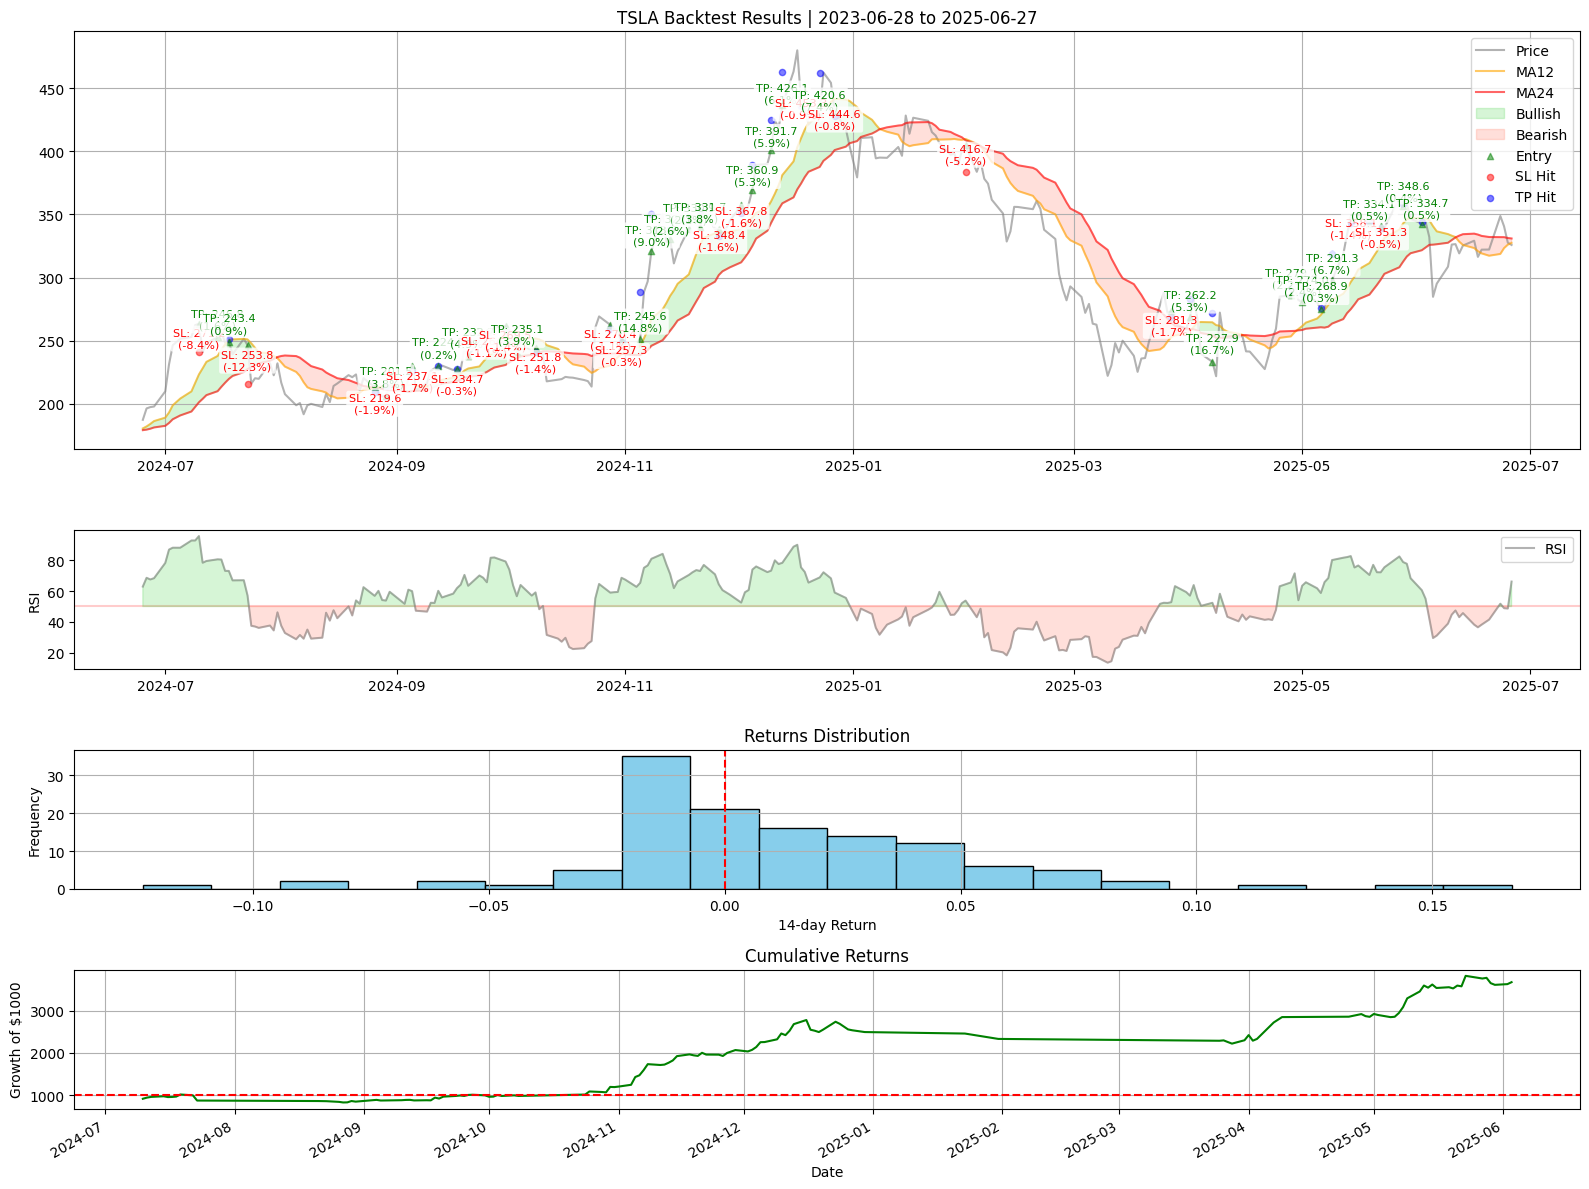


=== TSLA Backtest Results ===
Period: 2024-06-25 to 2025-06-26
Total Trades: 125
Win Rate: 57.6%
Avg Return: 1.12%
Avg Win: 3.51%
Avg Loss: -2.12%
Median Return: 2.95%
Avg Holding Days: 1.7
TP Hit Rate: 93.6%
SL Hit Rate: 6.4%
Max Gain: 16.68%
Max Loss: -12.33%
Return/Risk Ratio: 1.66
Profit Factor: 2.25

Avg Win/Loss 3.51% to -2.12%


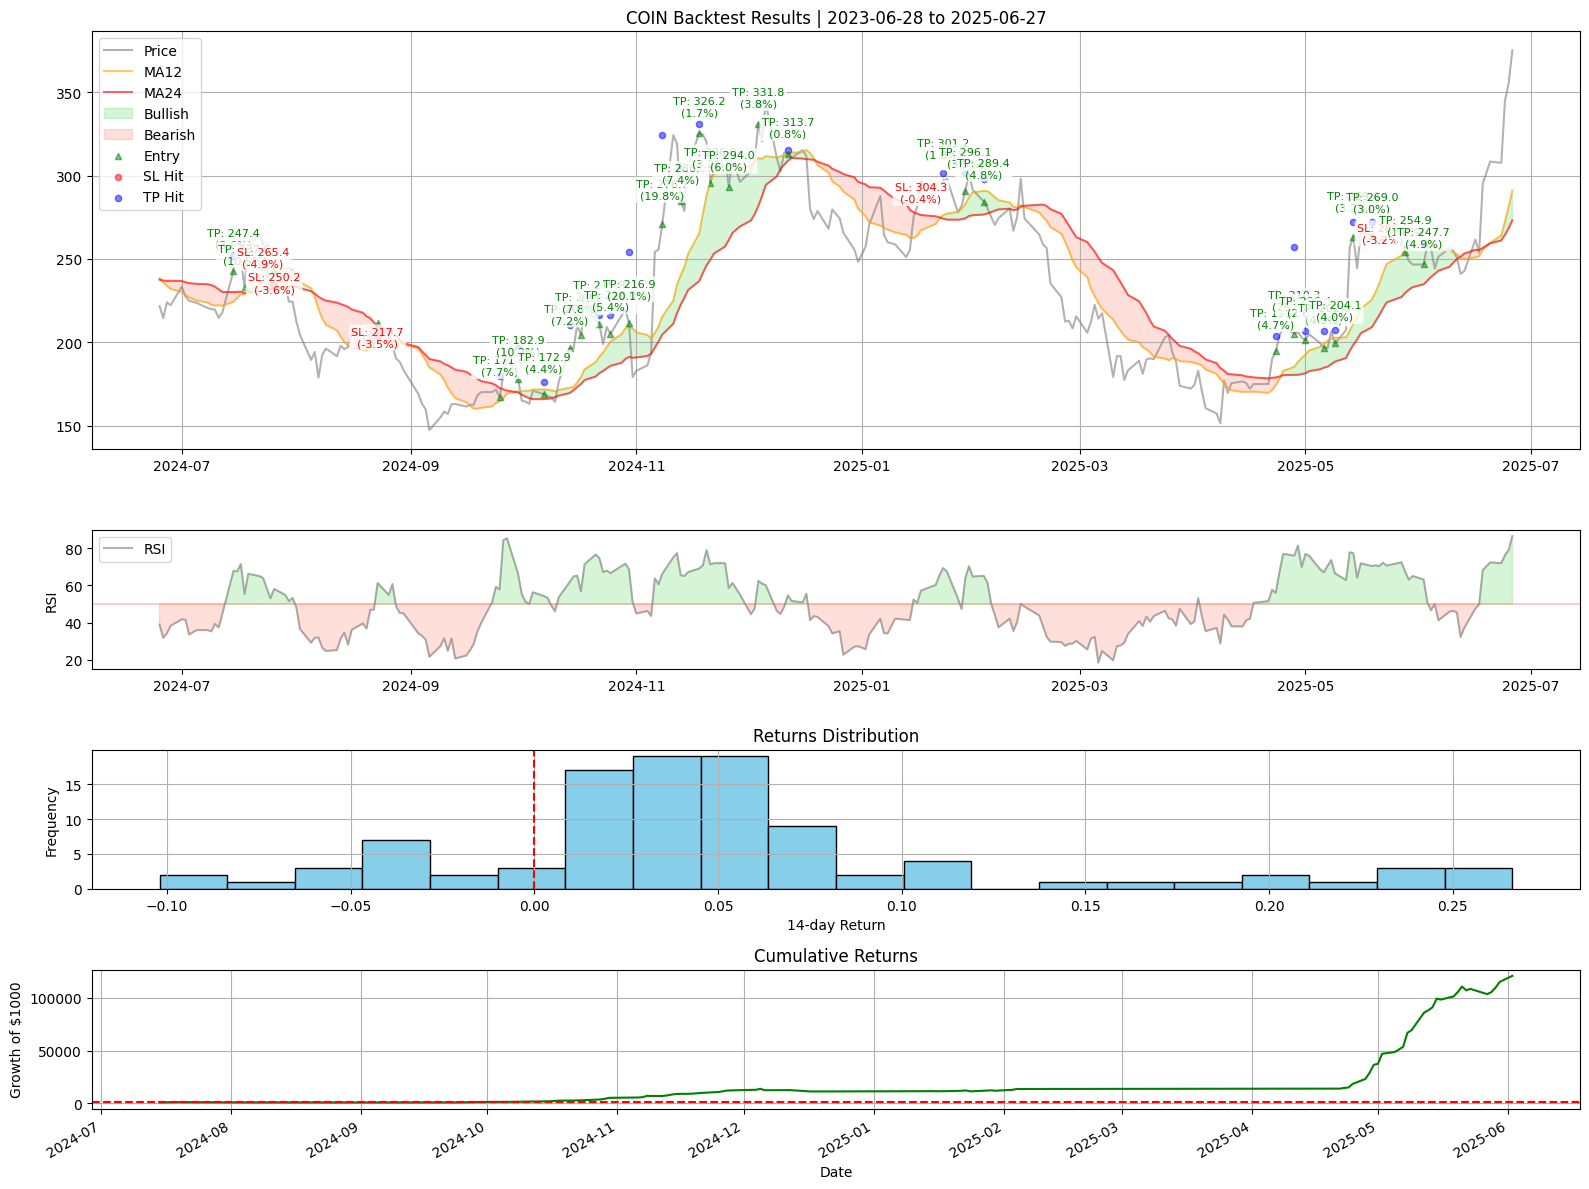


=== COIN Backtest Results ===
Period: 2024-06-25 to 2025-06-26
Total Trades: 100
Win Rate: 83.0%
Avg Return: 5.16%
Avg Win: 7.10%
Avg Loss: -4.30%
Median Return: 4.82%
Avg Holding Days: 3.2
TP Hit Rate: 83.0%
SL Hit Rate: 17.0%
Max Gain: 26.62%
Max Loss: -10.20%
Return/Risk Ratio: 1.65
Profit Factor: 8.06

Avg Win/Loss 7.10% to -4.30%


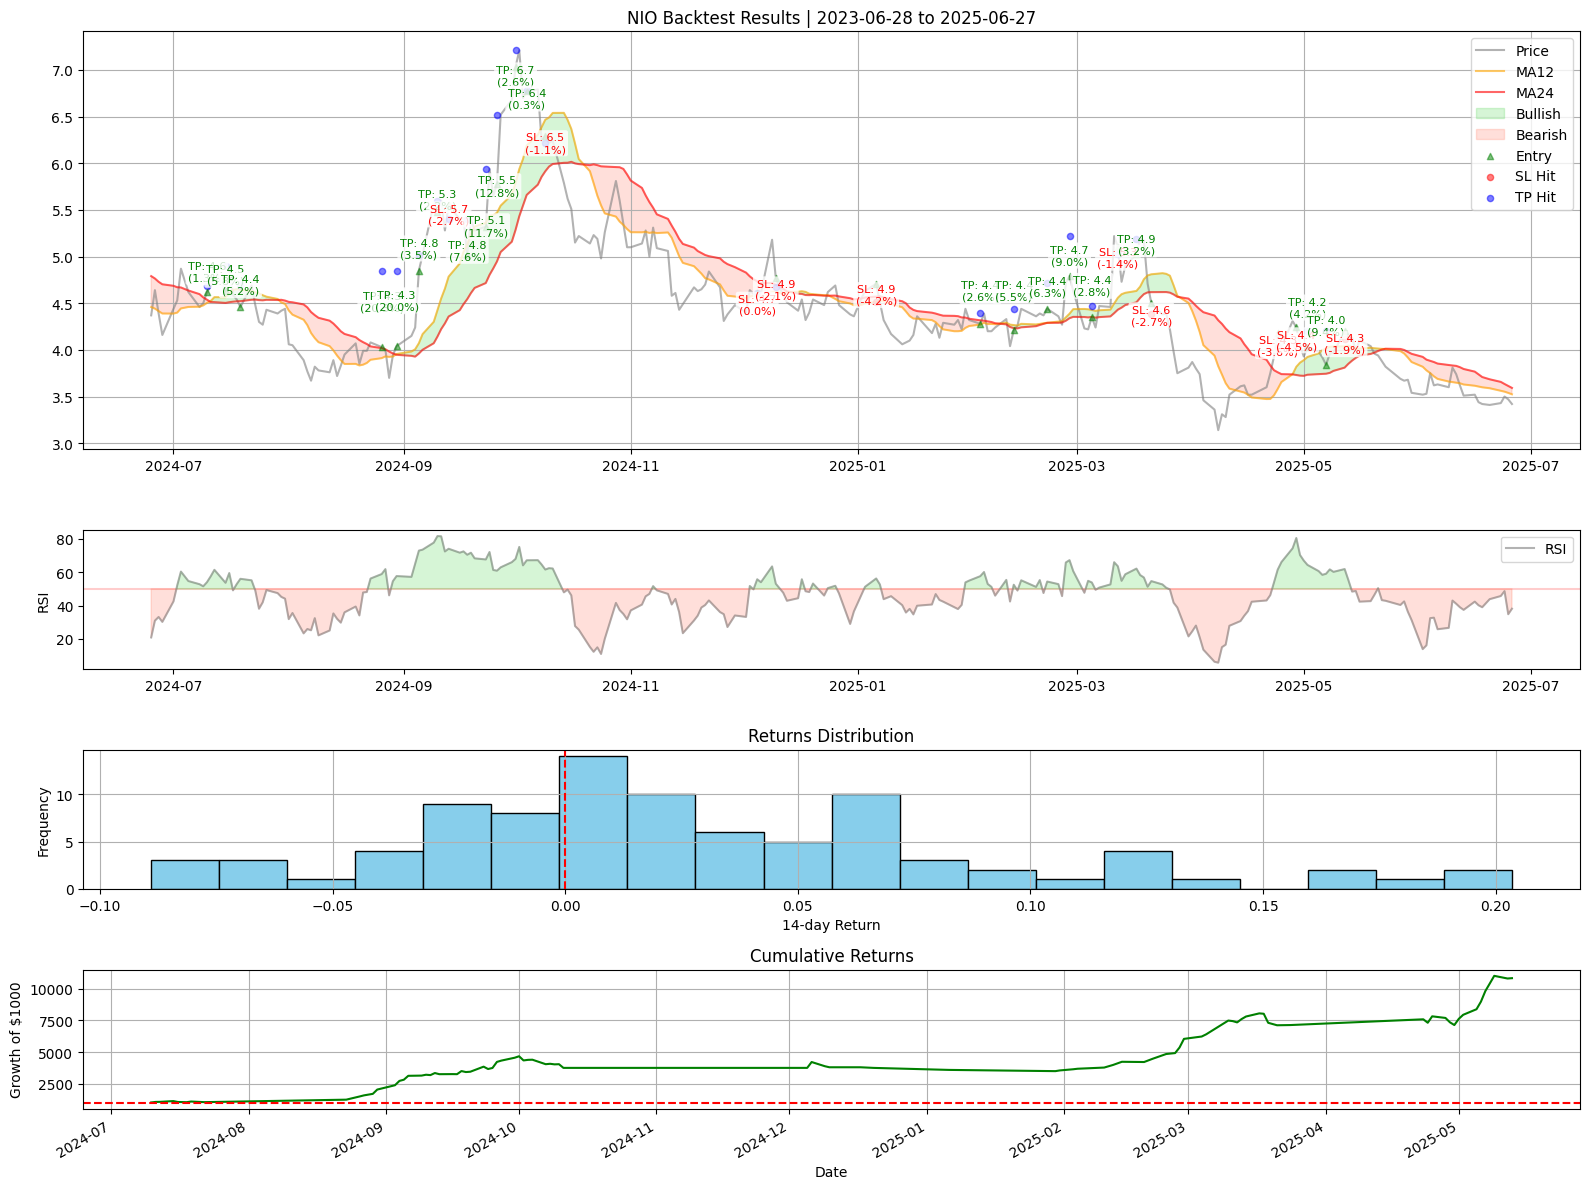


=== NIO Backtest Results ===
Period: 2024-06-25 to 2025-06-26
Total Trades: 89
Win Rate: 66.3%
Avg Return: 2.90%
Avg Win: 5.97%
Avg Loss: -3.14%
Median Return: 5.16%
Avg Holding Days: 2.0
TP Hit Rate: 82.0%
SL Hit Rate: 18.0%
Max Gain: 20.35%
Max Loss: -8.90%
Return/Risk Ratio: 1.90
Profit Factor: 3.74

Avg Win/Loss 5.97% to -3.14%


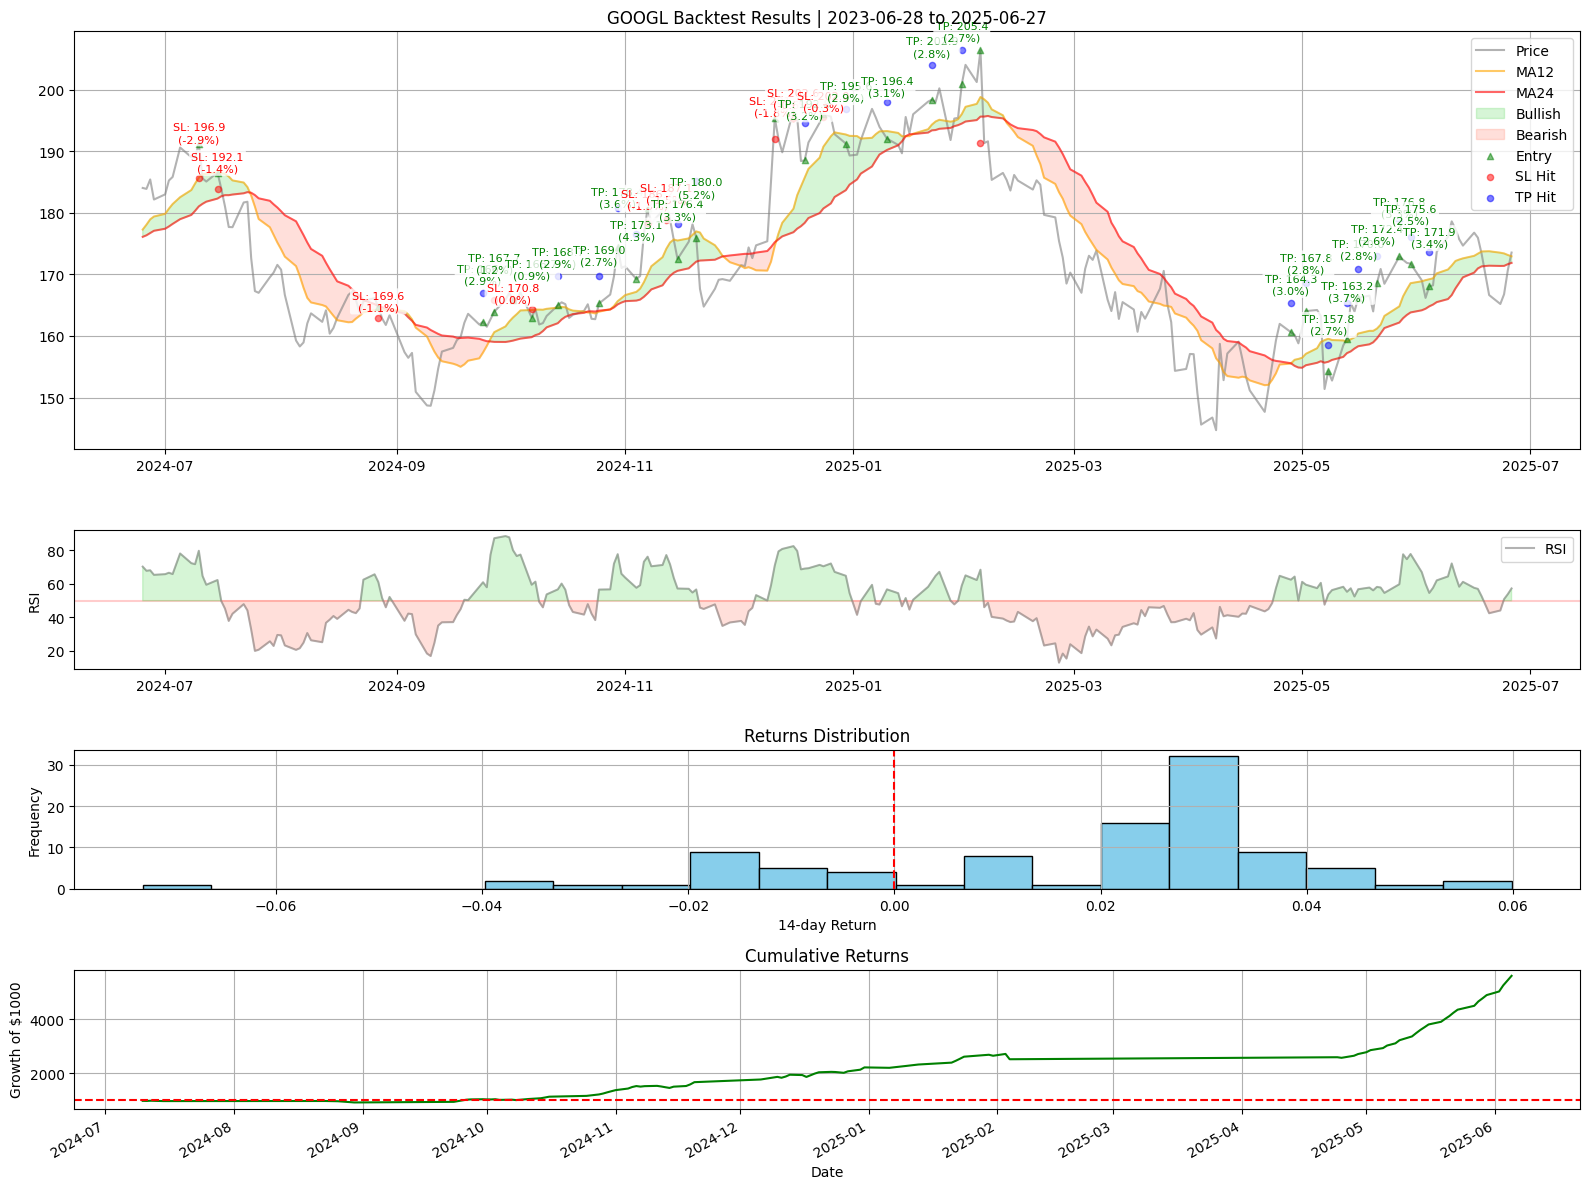


=== GOOGL Backtest Results ===
Period: 2024-06-25 to 2025-06-26
Total Trades: 98
Win Rate: 76.5%
Avg Return: 1.80%
Avg Win: 2.88%
Avg Loss: -1.71%
Median Return: 2.82%
Avg Holding Days: 3.7
TP Hit Rate: 66.3%
SL Hit Rate: 33.7%
Max Gain: 5.99%
Max Loss: -7.29%
Return/Risk Ratio: 1.69
Profit Factor: 5.50

Avg Win/Loss 2.88% to -1.71%


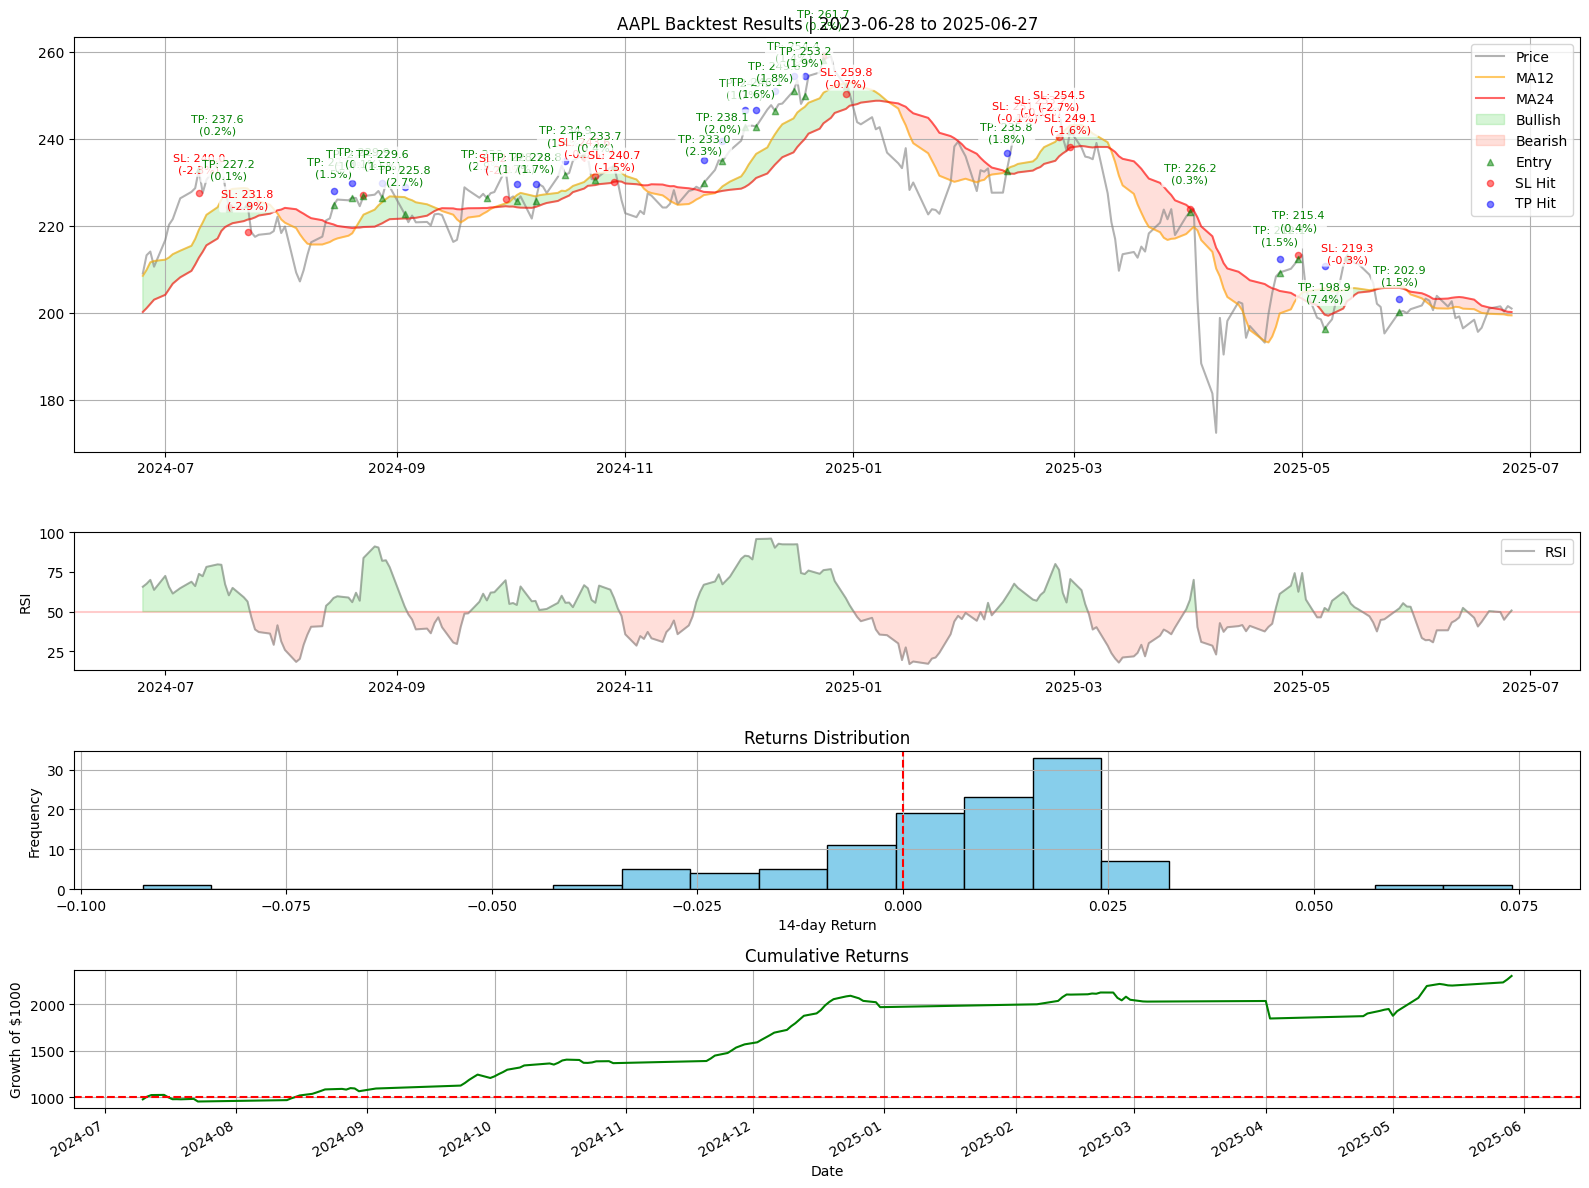


=== AAPL Backtest Results ===
Period: 2024-06-25 to 2025-06-26
Total Trades: 111
Win Rate: 72.1%
Avg Return: 0.77%
Avg Win: 1.67%
Avg Loss: -1.55%
Median Return: 1.63%
Avg Holding Days: 2.4
TP Hit Rate: 56.8%
SL Hit Rate: 43.2%
Max Gain: 7.41%
Max Loss: -9.25%
Return/Risk Ratio: 1.08
Profit Factor: 2.79

Avg Win/Loss 1.67% to -1.55%


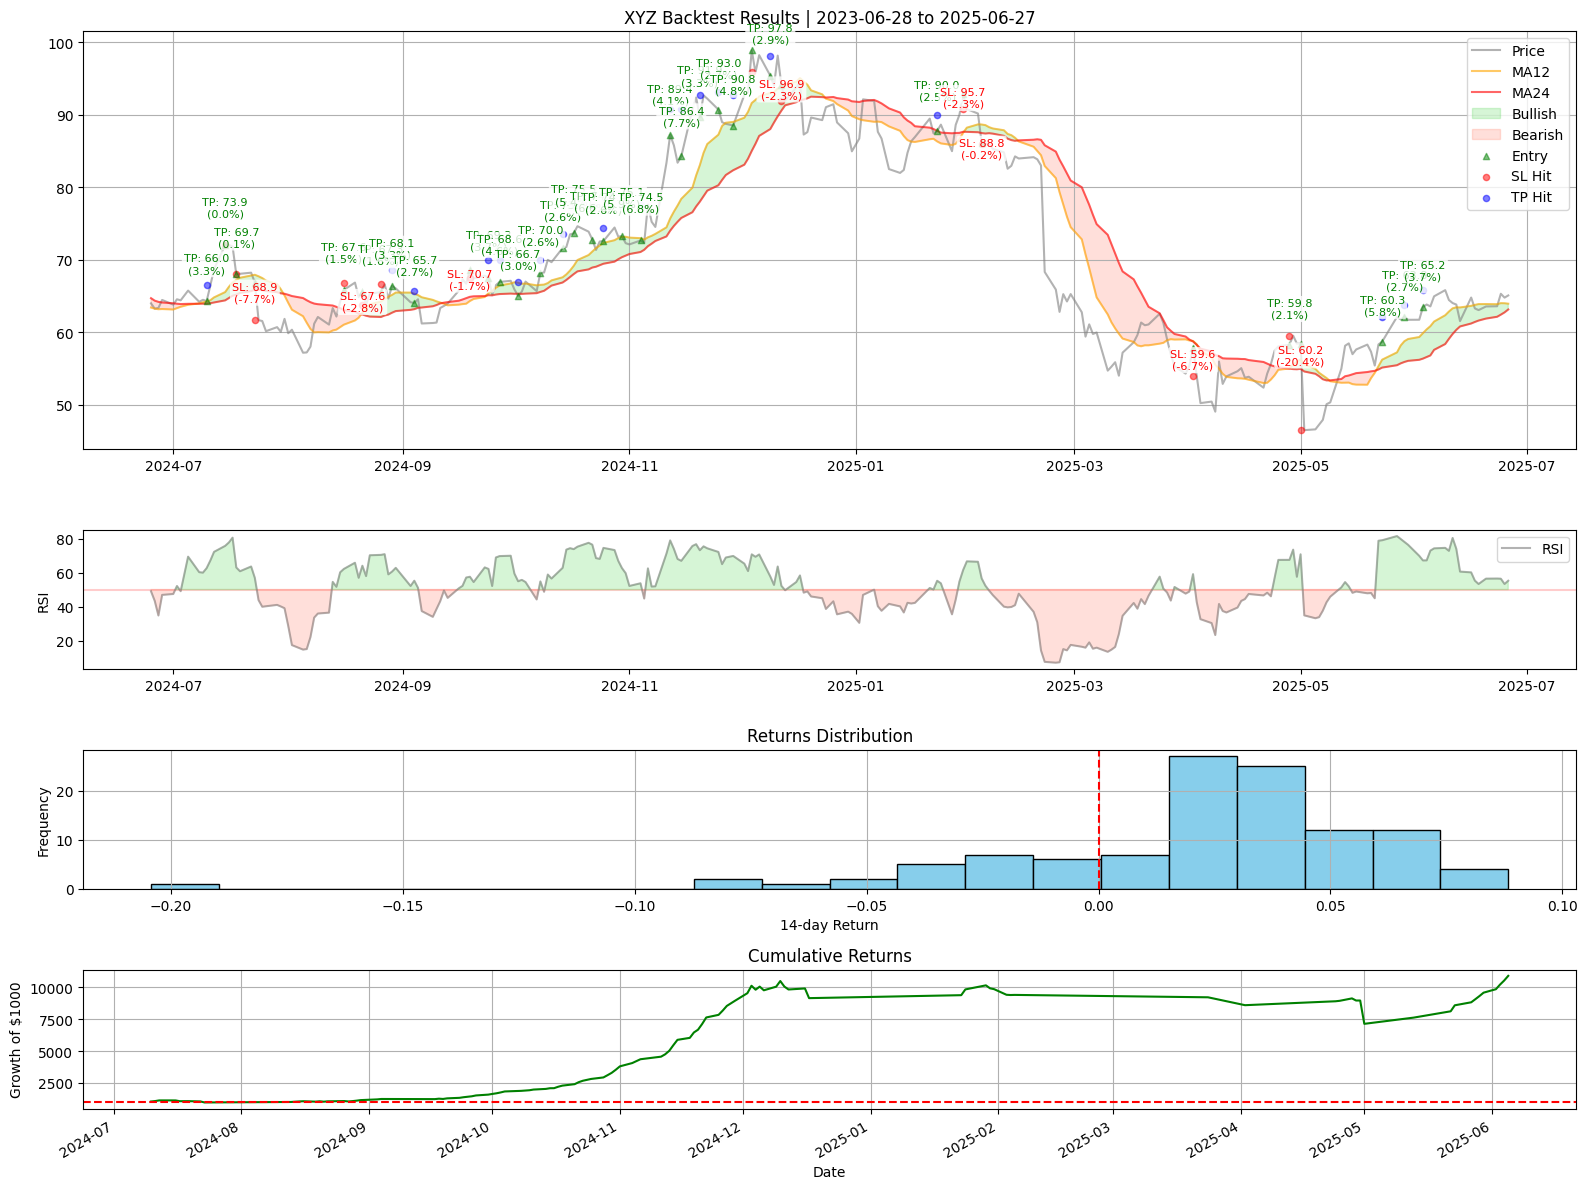


=== XYZ Backtest Results ===
Period: 2024-06-25 to 2025-06-26
Total Trades: 111
Win Rate: 80.2%
Avg Return: 2.26%
Avg Win: 3.78%
Avg Loss: -3.88%
Median Return: 3.50%
Avg Holding Days: 3.5
TP Hit Rate: 68.5%
SL Hit Rate: 31.5%
Max Gain: 8.83%
Max Loss: -20.43%
Return/Risk Ratio: 0.97
Profit Factor: 3.94

Avg Win/Loss 3.78% to -3.88%


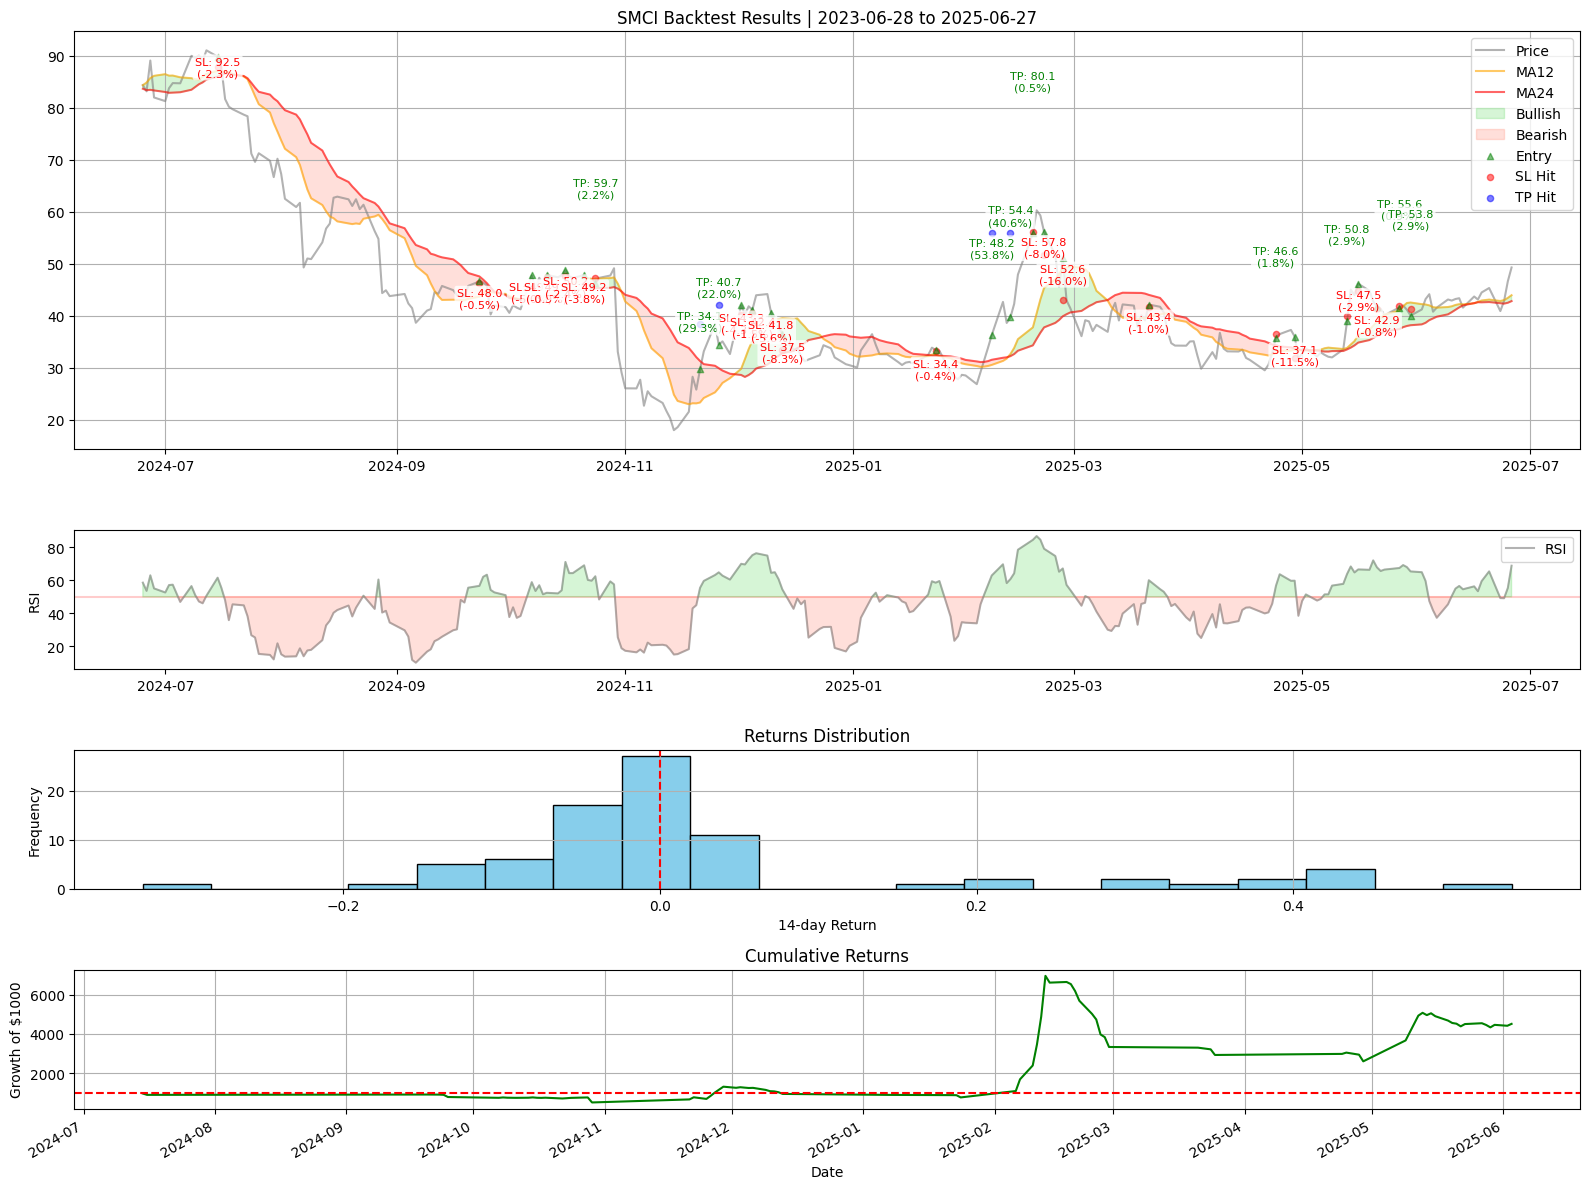


=== SMCI Backtest Results ===
Period: 2024-06-25 to 2025-06-26
Total Trades: 81
Win Rate: 39.5%
Avg Return: 2.92%
Avg Win: 15.35%
Avg Loss: -5.20%
Median Return: 2.77%
Avg Holding Days: 1.7
TP Hit Rate: 16.0%
SL Hit Rate: 84.0%
Max Gain: 53.80%
Max Loss: -32.68%
Return/Risk Ratio: 2.95
Profit Factor: 1.93

Avg Win/Loss 15.35% to -5.20%

=== Ticker Stats Summary ===
+----------+------------+---------------+---------------+--------------+-----------+------------+-----------------+--------------------+
| Ticker   | Win Rate   | TP Hit Rate   | SL Hit Rate   | Avg Return   | Avg Win   | Avg Loss   |   Profit Factor |   Avg Holding Days |
|----------+------------+---------------+---------------+--------------+-----------+------------+-----------------+--------------------|
| COIN     | 83.0%      | 83.0%         | 17.0%         | 5.16%        | 7.1%      | -4.3%      |            8.06 |                3.2 |
| CPNG     | 82.2%      | 77.1%         | 22.9%         | 2.6%         | 3.68%     

In [9]:
# Run backtest (Multiple Stocks)
all_stats = []
TICKERS = ["CPNG", "TSLA", "COIN", "NIO", "GOOGL", "AAPL", "XYZ", "SMCI"]

for tick in TICKERS:
    result = train_and_backtest(tick, train_years=2, show_every_n=3)
    trades, stats = result
    if trades.empty:
        print(f"{tick} has no trades after filtering.\n")
        continue
    
    stats_row = {
        'Ticker': tick,
        'Win Rate': stats['Win Rate'],
        'TP Hit Rate': stats['TP Hit Rate'],
        'SL Hit Rate': stats['SL Hit Rate'],
        'Avg Return': stats['Avg Return'],
        'Avg Win': stats['Avg Win'],
        'Avg Loss': stats['Avg Loss'],
        'Profit Factor': stats['Profit Factor'],
        'Avg Holding Days': stats['Avg Holding Days']
    }
    all_stats.append(stats_row)

summary_df = pd.DataFrame(all_stats)
summary_df = summary_df.sort_values(by='Profit Factor', ascending=False)

summary_df['Win Rate'] = pd.Series(summary_df['Win Rate']) * 100
summary_df['TP Hit Rate'] = pd.Series(summary_df['TP Hit Rate']) * 100
summary_df['SL Hit Rate'] = pd.Series(summary_df['SL Hit Rate']) * 100
summary_df['Avg Return'] = pd.Series(summary_df['Avg Return']) * 100
summary_df['Avg Win'] = pd.Series(summary_df['Avg Win']) * 100
summary_df['Avg Loss'] = pd.Series(summary_df['Avg Loss']) * 100

# Round and convert to string with '%'
summary_df['Win Rate'] = summary_df['Win Rate'].round(1).astype(str) + '%'
summary_df['TP Hit Rate'] = summary_df['TP Hit Rate'].round(1).astype(str) + '%'
summary_df['SL Hit Rate'] = summary_df['SL Hit Rate'].round(1).astype(str) + '%'
summary_df['Avg Return'] = summary_df['Avg Return'].round(2).astype(str) + '%'
summary_df['Avg Win'] = summary_df['Avg Win'].round(2).astype(str) + '%'
summary_df['Avg Loss'] = summary_df['Avg Loss'].round(2).astype(str) + '%'
summary_df['Profit Factor'] = summary_df['Profit Factor'].round(2).astype(str)
summary_df['Avg Holding Days'] = summary_df['Avg Holding Days'].round(1).astype(str)

print("\n=== Ticker Stats Summary ===")
print(tabulate(summary_df, headers='keys', tablefmt='psql', showindex=False))

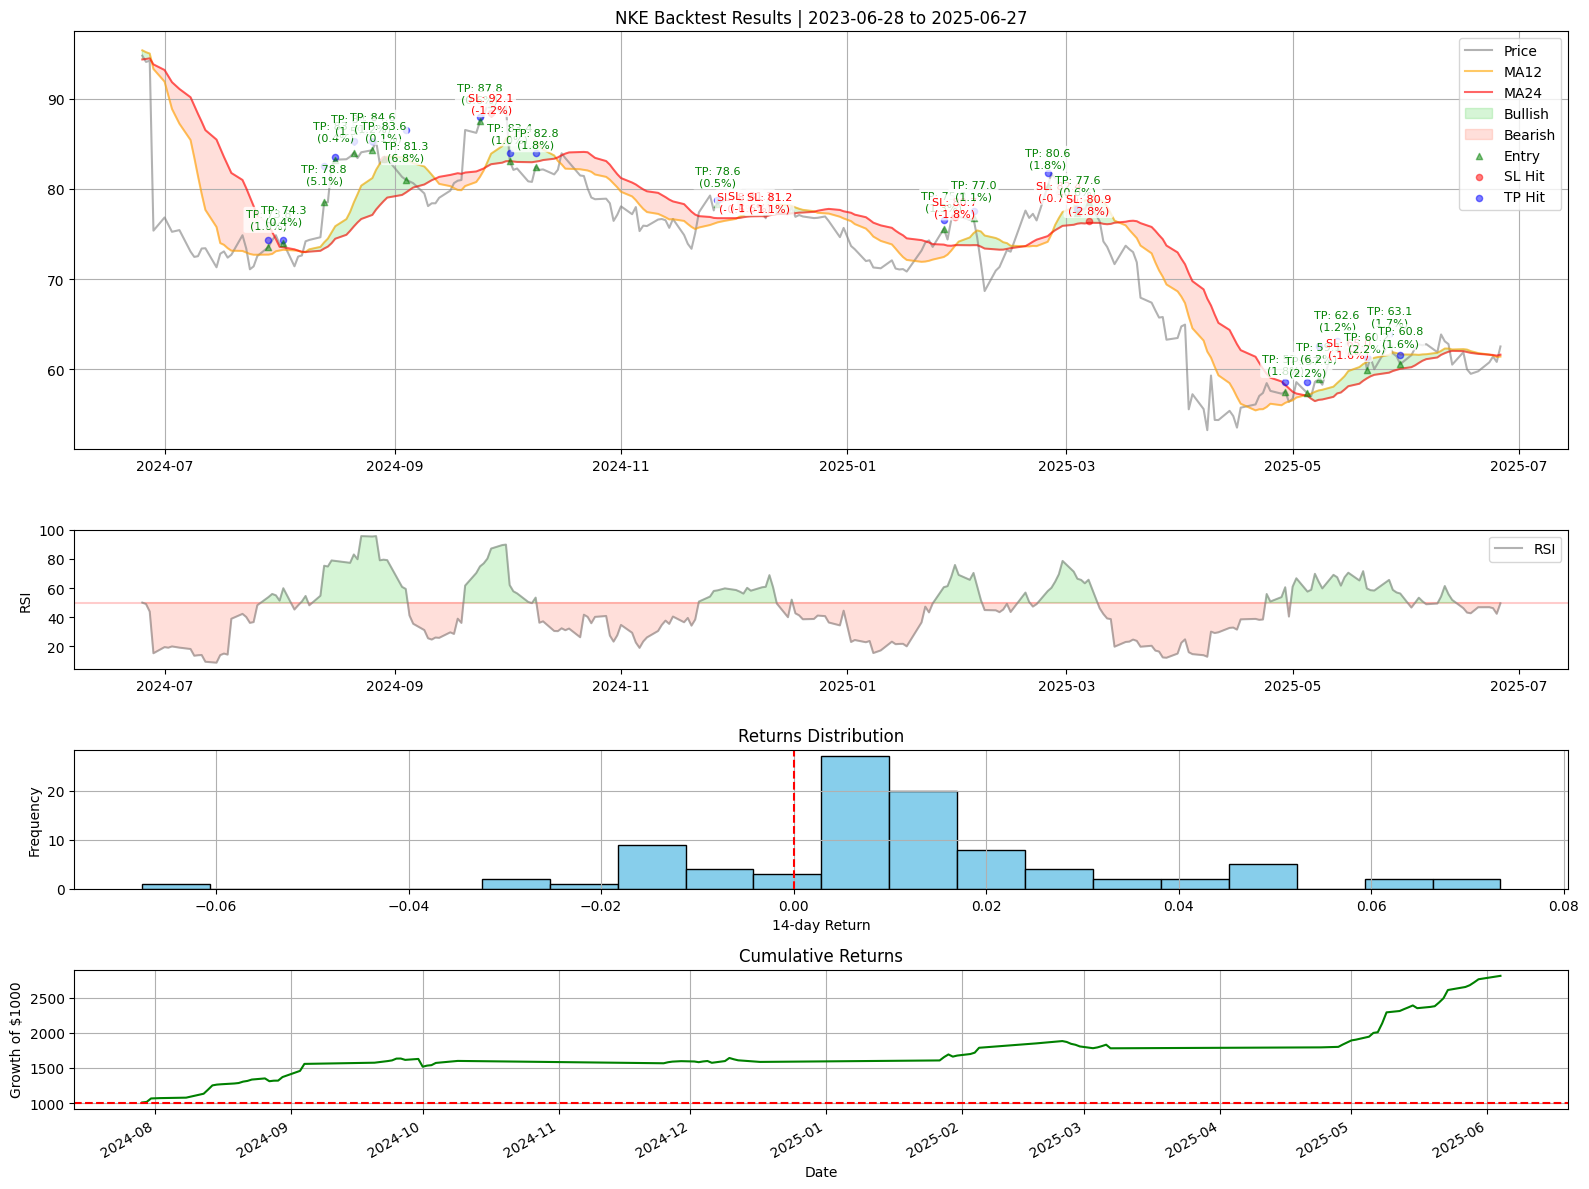


=== NKE Backtest Results ===
Period: 2024-06-25 to 2025-06-26
Total Trades: 92
Win Rate: 80.4%
Avg Return: 1.15%
Avg Win: 1.85%
Avg Loss: -1.70%
Median Return: 1.15%
Avg Holding Days: 2.8
TP Hit Rate: 78.3%
SL Hit Rate: 21.7%
Max Gain: 7.34%
Max Loss: -6.77%
Return/Risk Ratio: 1.08
Profit Factor: 4.46

Avg Win/Loss 1.85% to -1.70%

=== Ticker Stats Summary ===
+----------+------------+---------------+---------------+--------------+-----------------+--------------------+
| Ticker   | Win Rate   | TP Hit Rate   | SL Hit Rate   | Avg Return   |   Profit Factor |   Avg Holding Days |
|----------+------------+---------------+---------------+--------------+-----------------+--------------------|
| NKE      | 80.4%      | 78.3%         | 21.7%         | 1.15%        |            4.46 |            2.77174 |
+----------+------------+---------------+---------------+--------------+-----------------+--------------------+


In [10]:
# Run backtest (ONE STOCK)
all_stats = []

tick = "NKE"
result = train_and_backtest(tick, train_years=2, show_every_n=3)
trades, stats = result

stats_row = {
    'Ticker': tick,
    'Win Rate': stats['Win Rate'],
    'TP Hit Rate': stats['TP Hit Rate'],
    'SL Hit Rate': stats['SL Hit Rate'],
    'Avg Return': stats['Avg Return'],
    'Profit Factor': stats['Profit Factor'],
    'Avg Holding Days': stats['Avg Holding Days']
}

all_stats.append(stats_row)

summary_df = pd.DataFrame(all_stats)
summary_df = summary_df.sort_values(by='Win Rate', ascending=False)

summary_df['Win Rate'] = pd.Series(summary_df['Win Rate']) * 100
summary_df['TP Hit Rate'] = pd.Series(summary_df['TP Hit Rate']) * 100
summary_df['SL Hit Rate'] = pd.Series(summary_df['SL Hit Rate']) * 100
summary_df['Avg Return'] = pd.Series(summary_df['Avg Return']) * 100

# Round and convert to string with '%'
summary_df['Win Rate'] = summary_df['Win Rate'].round(1).astype(str) + '%'
summary_df['TP Hit Rate'] = summary_df['TP Hit Rate'].round(1).astype(str) + '%'
summary_df['SL Hit Rate'] = summary_df['SL Hit Rate'].round(1).astype(str) + '%'
summary_df['Avg Return'] = summary_df['Avg Return'].round(2).astype(str) + '%'
summary_df['Profit Factor'] = summary_df['Profit Factor'].round(2).astype(str)

print("\n=== Ticker Stats Summary ===")
print(tabulate(summary_df, headers='keys', tablefmt='psql', showindex=False))